In [86]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

In [87]:
base = Path("/media/12TB/Sujan/NWM/Csv/05_Boonville/All")

df_USGS = pd.read_csv("/media/12TB/Sujan/NWM/USGS_data/05_Boonville_06909000.csv",
                      parse_dates=["timestamp"]).set_index("timestamp")

# df_USGS["discharge_cumecs"] = df_USGS["discharge_cfs"] / 35.3147


In [88]:
def find_GH_with_tolerance(
    df_nwm,
    df_usgs,
    day_skip=7,
    day_bracket=7,
    q_tolerance=1.0,
    nwm_col="streamflow",
    usgs_q_col="discharge_cumecs",
    usgs_h_col="stage_ft",
):
    """
    For each NWM time t (after day_skip), search USGS data within [t - day_bracket, t + day_bracket].
    Take the mean of all USGS stages whose discharge lies within ±q_tolerance of the NWM discharge.
    If none match, return NaN. No interpolation.

    Parameters
    ----------
    df_nwm : DataFrame with DatetimeIndex and column nwm_col (default 'streamflow')
    df_usgs : DataFrame with DatetimeIndex and columns usgs_q_col ('discharge_cumecs'),
              usgs_h_col ('stage_ft')
    day_skip : days to skip from the start of df_nwm before processing
    day_bracket : half-window in days around each NWM time
    q_tolerance : discharge tolerance (same units as df_usgs[usgs_q_col])
    nwm_col, usgs_q_col, usgs_h_col : column names for flexibility
    """
    if not isinstance(df_nwm.index, pd.DatetimeIndex):
        raise TypeError("df_nwm must have a DatetimeIndex")
    if not isinstance(df_usgs.index, pd.DatetimeIndex):
        raise TypeError("df_usgs must have a DatetimeIndex")
    for col in [nwm_col]:
        if col not in df_nwm.columns:
            raise KeyError(f"df_nwm needs '{nwm_col}' column")
    for col in [usgs_q_col, usgs_h_col]:
        if col not in df_usgs.columns:
            raise KeyError(f"df_usgs needs '{usgs_q_col}' and '{usgs_h_col}' columns")

    # Keep needed cols and drop NaNs on USGS side
    nwm = df_nwm[[nwm_col]].copy()
    usgs = df_usgs[[usgs_q_col, usgs_h_col]].dropna().copy()

    # Sort by time for fast time-slicing
    nwm.sort_index(inplace=True)
    usgs.sort_index(inplace=True)

    # Apply day_skip
    start_time = nwm.index.min() + pd.Timedelta(days=day_skip)
    nwm_use = nwm.loc[nwm.index >= start_time].copy()

    out_records = []
    halfwin = pd.Timedelta(days=day_bracket)

    for t, row in nwm_use.iterrows():
        q = row[nwm_col]
        if pd.isna(q):
            out_records.append((t, np.nan))
            continue

        # Time window
        us = usgs.loc[t - halfwin : t + halfwin]
        if us.empty:
            out_records.append((t, np.nan))
            continue

        # Discharge band ± q_tolerance
        band = us[(us[usgs_q_col] >= q - q_tolerance) & (us[usgs_q_col] <= q + q_tolerance)]
        if band.empty:
            out_records.append((t, np.nan))
            continue

        gh_mean = float(band[usgs_h_col].mean())
        out_records.append((t, gh_mean))

    result = nwm.copy()
    gh_series = pd.DataFrame(out_records, columns=["time", "Computed_GH"]).set_index("time")
    result = result.join(gh_series, how="left")
    return result

def run_one(file_path, df_usgs, code,
            day_skip=0, day_bracket=10, q_tolerance=5.0):
    df_nwm = pd.read_csv(file_path, parse_dates=["time"]).set_index("time")
    out = find_GH_with_tolerance(
        df_nwm, df_usgs,
        day_skip=day_skip,
        day_bracket=day_bracket,
        q_tolerance=q_tolerance,
        nwm_col="streamflow",
        usgs_q_col="discharge_cumecs",
        usgs_h_col="stage_ft"
    )
    fill = out["Computed_GH"].notna().mean()
    print(f"{code}: filled {fill:.1%}  "
          f"(skip={day_skip}, window=±{day_bracket}d, tol={q_tolerance})")
    return out["Computed_GH"].rename(code)

In [89]:
# 1) Build wide DF on the union of **NWM** indices
wide = None
for h in range(6, 721, 6):  # 006..720
    code = f"{h:03d}"
    f = base / f"timeseries_{code}.csv"
    if not f.exists(): 
        continue
    s = run_one(f, df_USGS, code, day_skip=30, day_bracket=90, q_tolerance=5.0)
    if wide is None:
        wide = pd.DataFrame(index=s.index)
    wide = wide.join(s, how="outer")

# If nothing loaded, bail early
if wide is None:
    raise RuntimeError("No timeseries_* files were found or produced output.")

wide.sort_index(inplace=True)

# 2) Bring USGS stage onto the NWM union index via nearest-time match
# Using merge_asof for robust nearest alignment (set a tolerance you trust)
usgs_stage = (
    pd.merge_asof(
        left=wide.reset_index().rename(columns={"index":"time"}).sort_values("time"),
        right=df_USGS[["stage_ft"]].reset_index().rename(columns={"timestamp":"time"}).sort_values("time"),
        on="time", direction="nearest", tolerance=pd.Timedelta("3H")  # adjust tolerance as needed
    )
    .set_index("time")["stage_ft"]
    .rename("stage_ft_USGS_nearest")
)

# 3) Combine
merged_all = wide.join(usgs_stage, how="left")


006: filled 81.6%  (skip=30, window=±90d, tol=5.0)
012: filled 81.7%  (skip=30, window=±90d, tol=5.0)
018: filled 81.6%  (skip=30, window=±90d, tol=5.0)
024: filled 81.6%  (skip=30, window=±90d, tol=5.0)
030: filled 81.3%  (skip=30, window=±90d, tol=5.0)
036: filled 81.4%  (skip=30, window=±90d, tol=5.0)
042: filled 81.4%  (skip=30, window=±90d, tol=5.0)
048: filled 81.6%  (skip=30, window=±90d, tol=5.0)
054: filled 82.6%  (skip=30, window=±90d, tol=5.0)
060: filled 82.2%  (skip=30, window=±90d, tol=5.0)
066: filled 82.2%  (skip=30, window=±90d, tol=5.0)
072: filled 82.2%  (skip=30, window=±90d, tol=5.0)
078: filled 82.4%  (skip=30, window=±90d, tol=5.0)
084: filled 82.4%  (skip=30, window=±90d, tol=5.0)
090: filled 81.9%  (skip=30, window=±90d, tol=5.0)
096: filled 82.1%  (skip=30, window=±90d, tol=5.0)
102: filled 82.7%  (skip=30, window=±90d, tol=5.0)
108: filled 82.6%  (skip=30, window=±90d, tol=5.0)
114: filled 82.3%  (skip=30, window=±90d, tol=5.0)
120: filled 82.8%  (skip=30, wi

/tmp/ipykernel_322926/1108148301.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  on="time", direction="nearest", tolerance=pd.Timedelta("3H")  # adjust tolerance as needed


In [90]:
merged_all

,006,012,018,024,030,036,042,048,054,060,...,672,678,684,690,696,702,708,714,720,stage_ft_USGS_nearest
time,,,,,,,,,,,,,,,,,,,,,
2018-09-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.24
2018-09-17 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.25
2018-09-17 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.21
2018-09-17 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.16
2018-09-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 00:00:00,2.990630,2.972229,2.972229,2.972229,3.022886,3.087193,3.136331,3.151489,3.190099,3.236986,...,5.687231,5.624828,5.136236,5.413704,4.759057,4.432660,4.979386,4.800164,5.584884,3.06
2024-12-30 06:00:00,2.908307,2.904793,2.904793,2.908307,2.912254,3.012840,3.058788,3.104630,3.112014,3.126058,...,5.365974,5.697714,5.689839,5.142536,5.427045,4.772292,4.449955,5.018523,4.796703,3.08
2024-12-30 12:00:00,2.878760,2.867399,2.867399,2.878760,2.897463,2.909160,2.990630,3.034021,3.048675,3.034021,...,4.893740,5.365079,5.752241,5.765870,5.168824,5.427045,4.779412,4.449955,5.041656,3.12


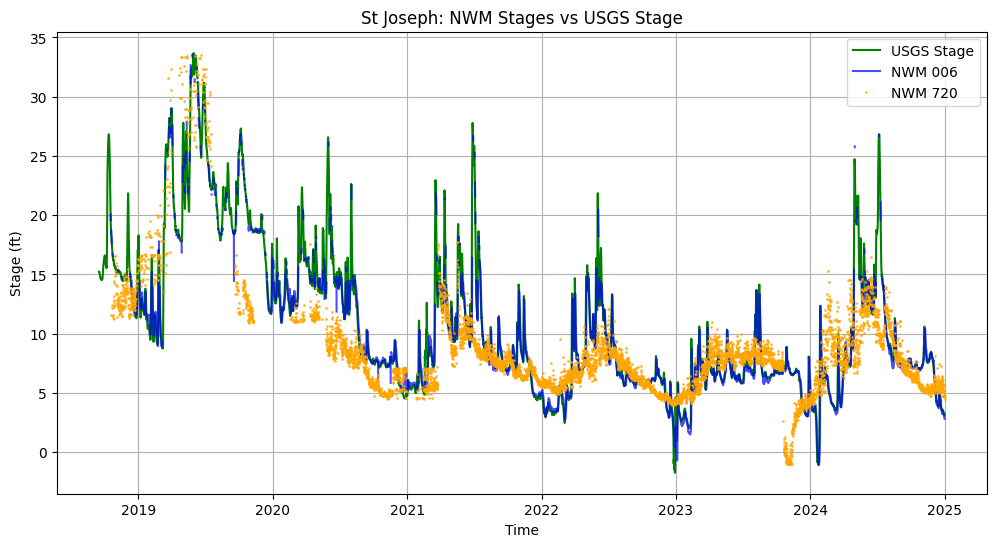

In [93]:
# Example plot for a couple horizons if present
plt.figure(figsize=(12, 6)) 
plt.plot(merged_all.index, merged_all["stage_ft_USGS_nearest"],  label="USGS Stage", color='green')
plt.plot(merged_all.index, merged_all.get("006"), label="NWM 006", alpha=0.7, color='blue')
plt.plot(merged_all.index, merged_all.get("720"),"o", label="NWM 720", alpha=0.7, color='orange', markersize=1)
plt.xlabel("Time")
plt.ylabel("Stage (ft)")
plt.title("St Joseph: NWM Stages vs USGS Stage")
plt.legend()
plt.grid()
plt.show()

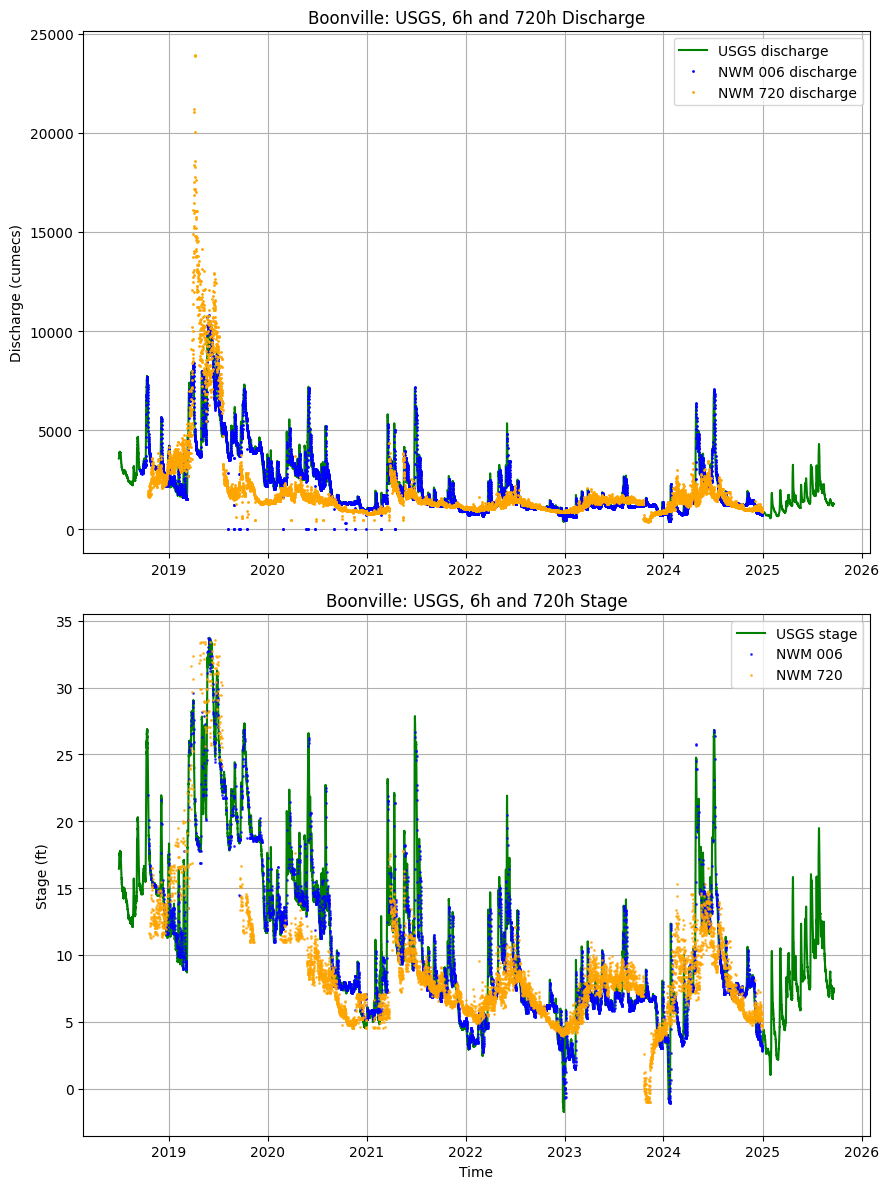

In [102]:
#plot a figure with 3 subplots: USGS , NWM 006, NWM 720 stage and discharge timeseries
df_006_NWM= pd.read_csv("/media/12TB/Sujan/NWM/Csv/05_Boonville/All/timeseries_006.csv", parse_dates=["time"]).set_index("time")
df_720_NWM= pd.read_csv("/media/12TB/Sujan/NWM/Csv/05_Boonville/All/timeseries_720.csv", parse_dates=["time"]).set_index("time")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 12))
ax1.plot(df_USGS.index, df_USGS["discharge_cumecs"],  label="USGS discharge", color='green')
ax1.plot(df_006_NWM.index, df_006_NWM["streamflow"],"o", label="NWM 006 discharge", color='blue', markersize=1)
ax1.plot(df_720_NWM.index, df_720_NWM["streamflow"],"o", label="NWM 720 discharge", color='orange', markersize=1)

ax2.plot(df_USGS.index, df_USGS["stage_ft"],  label="USGS stage", color='green' )
ax2.plot(merged_all.index, merged_all.get("006"), "o", label="NWM 006", alpha=0.7, color='blue', markersize=1  )
ax2.plot(merged_all.index, merged_all.get("720"),"o", label="NWM 720", alpha=0.7, color='orange', markersize=1)

ax2.set_xlabel("Time")
ax1.set_ylabel("Discharge (cumecs)")
ax1.set_title("Boonville: USGS, 6h and 720h Discharge")
ax1.legend()
ax1.grid()  
ax2.set_ylabel("Stage (ft)")
ax2.set_title("Boonville: USGS, 6h and 720h Stage")
ax2.legend()
ax2.grid()
plt.tight_layout()



